In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import fnmatch
import csv
import pickle
import warnings
import torch

warnings.filterwarnings('ignore')

### Required for building NN ###
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from termcolor import colored
import tensorflow.keras.backend as K

### Load and prepare data

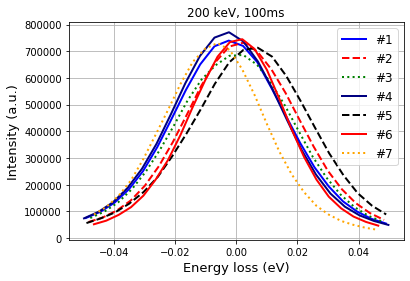

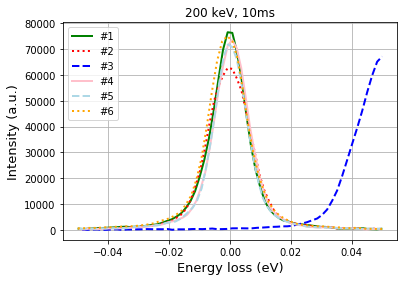

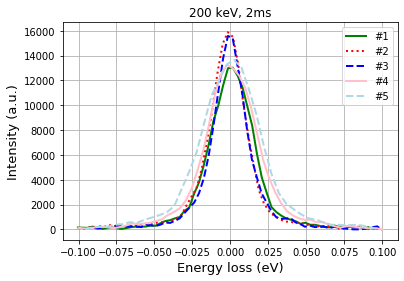


 ************************ Data files have been prepared ***************************** 



In [36]:
mode = 'Mixture'
%run EELS-ZLP-Mar.py



### Find uncertainties on data

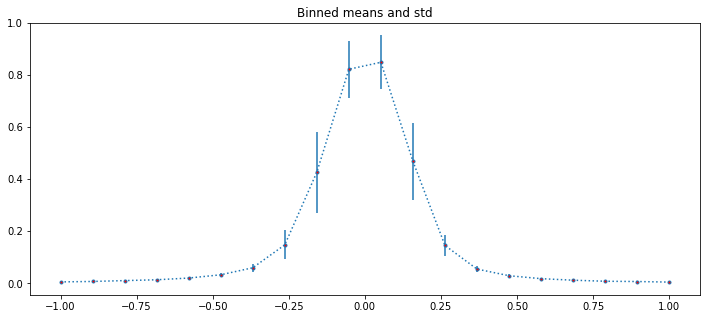

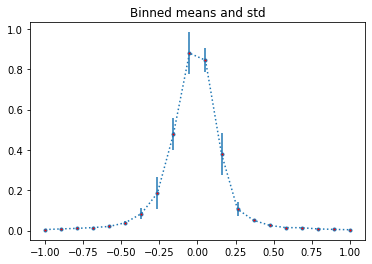

The total number of training datapoints is 214 and validation points is 116


In [37]:
%run Functions.ipynb
fig = plt.gcf()
from copy import copy

time = 10
nbins = 20
minval = -1
maxval = +1


x_train, y_train, x_val, y_val = prepare_mix_data(time)

# Store output vectors for training
df_train, cuts1_t, cuts2_t = ewd(x_train, y_train)
mean_t, std_t, count_t= binned_statistics(x_train, y_train)
variance_vector_t = vectorize_variance(x_train, y_train)
mean_vector_t = vectorize_mean(x_train, y_train)
#create one vector with (x_train, y_train, sigma_train)
df_train = np.c_[df_train[:,0], mean_vector_t, variance_vector_t]


# Store output vectors for validation
df_val, cuts1_v, cuts2_v = ewd(x_val, y_val)
mean_v, std_v, count_v= binned_statistics(x_val, y_val)
variance_vector_v = vectorize_variance(x_val, y_val)
mean_vector_v = vectorize_mean(x_val, y_val)
#create one vector with (x_train, y_train, sigma_train)
df_val = np.c_[df_val[:,0], mean_vector_v, variance_vector_v]


### Apply smoothing to the signal
N_train = len(df_train[:,0])
N_test = len(df_val[:,0])
smoothing_window_train = 100
smooth_y = np.array(smooth(df_train[:,1], 14))
smooth_y_test = np.array(smooth(df_val[:,1], 14))


# Create a plot of the mean & std 
plot_uncertainties(x_train, y_train, nbins, minval, maxval)
fig.set_size_inches(12, 5)
plt.show()

plot_uncertainties(x_val, y_val, nbins, minval, maxval)
fig.set_size_inches(12, 5)
plt.show()

print("The total number of training datapoints is", N_train, "and validation points is", N_test)


## Neural Network 

### Create architecture

In [38]:
def make_model(inputs, n_outputs):

    hidden_layer_1 = tf.layers.dense(inputs, 5, activation=tf.nn.sigmoid)
    hidden_layer_2 = tf.layers.dense(hidden_layer_1, 5, activation=tf.nn.sigmoid)
    hidden_layer_3 = tf.layers.dense(hidden_layer_2, 5, activation=tf.nn.relu)
    hidden_layer_3 = tf.layers.dropout(hidden_layer_3, 0.3)
    output = tf.layers.dense(hidden_layer_3, n_outputs, name='outputs', reuse=tf.AUTO_REUSE)

    return output



### Prepare data for training

In [40]:
tf.reset_default_graph()
from copy import copy

x = tf.placeholder("float", [None, 2])
y = tf.placeholder("float", [None, 1])
sigma = tf.placeholder("float", [None, 1])

N_train = len(df_train[:,0])
N_test = len(df_val[:,0])

predictions = make_model(x,1)

### Define cost and optimizer
cost = tf.reduce_mean(tf.square((y-predictions)/sigma), name="cost_function")
eta = 5e-3
optimizer = tf.train.AdamOptimizer(learning_rate=eta, beta1=0.9, beta2=0.999, epsilon=1e-08, ).minimize(cost)

train_x = add_time(df_train, time)
train_sigma = df_train[:,2].reshape(N_train,1)
test_x = add_time(df_val, time)
test_sigma = df_val[:,2].reshape(N_test,1)

chi_array = []


i = 0
Nrep = 100

while i < Nrep:

    train_y = copy(df_train[:,1]).reshape(N_train,1)  ## train_y = smooth_y in case of smoothing
    train_y += np.random.normal(0, train_sigma) # Create one replica of the training set
    #print("Shape of this round of Monte Carlo replicas is:", train_y.shape)

    test_y = copy(df_val[:,1]).reshape(N_test,1)
    test_y +=  np.random.normal(0, test_sigma) # Create Monte Carlo points


    #print("Example of one training x, shape (,2):", train_x[80,:])
    #print("Example of one training y, shape (,1):", train_y[80])

    # Scaling input features to help the minimizer.
    train_scaler = StandardScaler()
    train_scaler.fit(train_x[:,0].reshape(1,-1))
    test_scaler = StandardScaler()
    test_scaler.fit(test_x[:,0].reshape(1,-1))

    ### Train and validate

    training_epochs = 40000
    max_rising_epochs = 9000 #The amount of epochs the minimzer is allowed to overfit before it stops
    display_step = 5000
    prev_test_cost = 100
    prev_epoch=0
    avg_cost = 0.0

    predict_xx = np.linspace(-1.5, 1.5, N_train)
    predict_x = np.c_[predict_xx, 0*predict_xx+1]

    array_train = []
    array_test = []
    
    print("Start training on", '%04d' %(N_train), "and validating on", '%0.4d' %(N_test), "samples")

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        for epoch in range(training_epochs):

            _, c = sess.run([optimizer, cost], 
                            feed_dict={
                                x: train_x,
                                y: train_y,
                                sigma: train_sigma
                            })
            avg_cost = c 

            test_cost = cost.eval({x: test_x, y: test_y, sigma: test_sigma})


            if epoch % display_step == 0:
                print("Epoch:", '%04d' % (epoch+1), "| Training cost=", "{:.9f}".format(avg_cost), "| Validation cost=", "{:.9f}".format(test_cost))
                array_train.append(avg_cost)
                array_test.append(test_cost)

            if test_cost >= prev_test_cost and epoch-prev_epoch >= max_rising_epochs:
                print(colored("\n The session stopped because of overfitting...","red"))
                print("Start overfitting at epoch:", '%04d' % (epoch), "| Validation cost =", "{:.9f}".format(test_cost), "| Train cost=", "{:.9f}".format(avg_cost))
                break


            elif test_cost < prev_test_cost:
                prev_test_cost = test_cost
                prev_epoch = epoch


        print("Optimization Finished!")
        predictions_values = sess.run(predictions, 
                            feed_dict={
                                x: train_x,
                                y: train_y 
                            })
    sess.close()

    # save to csv file
    from datetime import datetime
    predictions_values = predictions_values.reshape(N_train,)

    #foot = np.array(seednumber)
    a = np.array(train_x[:,0])
    b = np.array(train_y)
    c = np.array(predictions_values)
    d = array_train
    e = array_test
    
    chi_array.append(d[-1])

    seed = 22

    now = datetime.now()
    dt_string = now.strftime("%d.%m.%Y %H:%M:%S")
    np.savetxt('Data/Results/%(date)s.%(seed)x(a).csv' % {"date": dt_string, "seed":seed}, list(zip(a,b,c)),  delimiter=',',  header="Training inputs, Training outputs, Predictions", fmt='%f')
    np.savetxt('Data/Results/%(date)s.%(seed)x(b).csv' % {"date": dt_string, "seed":seed}, list(zip(d,e)),  delimiter=',',  header="Chi2_train, Chi2_test", fmt='%f')
    print(i)
    i+=1

Start training on 0214 and validating on 0116 samples
Epoch: 0001 | Training cost= 2720.406738281 | Validation cost= 1770.222778320
Epoch: 5001 | Training cost= 7.875180244 | Validation cost= 14.752410889
Epoch: 10001 | Training cost= 3.776249170 | Validation cost= 6.691552639
Epoch: 15001 | Training cost= 1.875364661 | Validation cost= 2.997527599
Epoch: 20001 | Training cost= 1.716634750 | Validation cost= 2.638461113
Epoch: 25001 | Training cost= 4.665855885 | Validation cost= 5.952748775
Epoch: 30001 | Training cost= 1.677571535 | Validation cost= 2.485441685
Epoch: 35001 | Training cost= 1.710528255 | Validation cost= 2.482546329
Optimization Finished!
0
Start training on 0214 and validating on 0116 samples
Epoch: 0001 | Training cost= 14401.130859375 | Validation cost= 10823.498046875
Epoch: 5001 | Training cost= 8.205754280 | Validation cost= 16.326320648
Epoch: 10001 | Training cost= 6.288730145 | Validation cost= 13.582784653
Epoch: 15001 | Training cost= 4.822351933 | Validat

Epoch: 20001 | Training cost= 1.567078352 | Validation cost= 2.110295296
Epoch: 25001 | Training cost= 1.524084926 | Validation cost= 2.012752056
Epoch: 30001 | Training cost= 1.556451917 | Validation cost= 2.275017738
Epoch: 35001 | Training cost= 1.500091076 | Validation cost= 1.973056555
Optimization Finished!
12
Start training on 0214 and validating on 0116 samples
Epoch: 0001 | Training cost= 360.703125000 | Validation cost= 106.392395020
Epoch: 5001 | Training cost= 1.722873449 | Validation cost= 2.529085875
Epoch: 10001 | Training cost= 1.350244641 | Validation cost= 2.081072807
Epoch: 15001 | Training cost= 1.322153449 | Validation cost= 2.167815685
Epoch: 20001 | Training cost= 1.383214355 | Validation cost= 2.022759199

 The session stopped because of overfitting...
Start overfitting at epoch: 24596 | Validation cost = 2.023389101 | Train cost= 1.366260648
Optimization Finished!
13
Start training on 0214 and validating on 0116 samples
Epoch: 0001 | Training cost= 1600.4998779

Epoch: 5001 | Training cost= 11.236062050 | Validation cost= 22.170158386
Epoch: 10001 | Training cost= 6.839694500 | Validation cost= 13.402054787
Epoch: 15001 | Training cost= 2.196540356 | Validation cost= 3.422773838
Epoch: 20001 | Training cost= 1.621517658 | Validation cost= 2.244535208
Epoch: 25001 | Training cost= 1.454700828 | Validation cost= 1.863962531
Epoch: 30001 | Training cost= 1.366206408 | Validation cost= 1.787355304
Epoch: 35001 | Training cost= 1.310259223 | Validation cost= 1.802480459
Optimization Finished!
26
Start training on 0214 and validating on 0116 samples
Epoch: 0001 | Training cost= 66.711151123 | Validation cost= 29.809305191
Epoch: 5001 | Training cost= 13.908992767 | Validation cost= 24.941316605
Epoch: 10001 | Training cost= 13.908448219 | Validation cost= 24.925836563
Epoch: 15001 | Training cost= 13.908448219 | Validation cost= 24.925716400
Epoch: 20001 | Training cost= 13.908446312 | Validation cost= 24.925848007
Epoch: 25001 | Training cost= 13.9

Epoch: 25001 | Training cost= 1.892159462 | Validation cost= 2.911794662
Epoch: 30001 | Training cost= 1.819187045 | Validation cost= 2.731147289
Epoch: 35001 | Training cost= 1.755807042 | Validation cost= 2.578600645
Optimization Finished!
38
Start training on 0214 and validating on 0116 samples
Epoch: 0001 | Training cost= 81121.132812500 | Validation cost= 84791.070312500
Epoch: 5001 | Training cost= 7.241624832 | Validation cost= 14.223425865
Epoch: 10001 | Training cost= 4.527558327 | Validation cost= 8.192501068
Epoch: 15001 | Training cost= 1.474284530 | Validation cost= 2.202895403
Epoch: 20001 | Training cost= 2.070528030 | Validation cost= 2.657819748
Epoch: 25001 | Training cost= 1.287458301 | Validation cost= 1.918478489
Epoch: 30001 | Training cost= 1.275163054 | Validation cost= 1.900563717
Epoch: 35001 | Training cost= 1.268271327 | Validation cost= 1.893228769
Optimization Finished!
39
Start training on 0214 and validating on 0116 samples
Epoch: 0001 | Training cost= 3

Epoch: 20001 | Training cost= 1.339269757 | Validation cost= 2.114171028

 The session stopped because of overfitting...
Start overfitting at epoch: 24492 | Validation cost = 3.543918848 | Train cost= 2.767107248
Optimization Finished!
50
Start training on 0214 and validating on 0116 samples
Epoch: 0001 | Training cost= 35167.195312500 | Validation cost= 33191.265625000
Epoch: 5001 | Training cost= 13.129156113 | Validation cost= 24.609699249
Epoch: 10001 | Training cost= 9.830286980 | Validation cost= 16.727384567
Epoch: 15001 | Training cost= 3.487443686 | Validation cost= 5.691314220
Epoch: 20001 | Training cost= 1.751576185 | Validation cost= 2.417691708
Epoch: 25001 | Training cost= 1.510201693 | Validation cost= 2.021471262
Epoch: 30001 | Training cost= 1.454036117 | Validation cost= 1.873921752
Epoch: 35001 | Training cost= 2.666703463 | Validation cost= 1.915126920
Optimization Finished!
51
Start training on 0214 and validating on 0116 samples
Epoch: 0001 | Training cost= 17725

Optimization Finished!
63
Start training on 0214 and validating on 0116 samples
Epoch: 0001 | Training cost= 98.858451843 | Validation cost= 68.829887390
Epoch: 5001 | Training cost= 4.796322346 | Validation cost= 8.713036537
Epoch: 10001 | Training cost= 2.019685507 | Validation cost= 3.096760511
Epoch: 15001 | Training cost= 1.632774115 | Validation cost= 1.990477324
Epoch: 20001 | Training cost= 1.574539900 | Validation cost= 1.868946075
Epoch: 25001 | Training cost= 1.576798916 | Validation cost= 1.908657432
Epoch: 30001 | Training cost= 1.571712732 | Validation cost= 1.815447569
Epoch: 35001 | Training cost= 11.925275803 | Validation cost= 19.621322632
Optimization Finished!
64
Start training on 0214 and validating on 0116 samples
Epoch: 0001 | Training cost= 86588.859375000 | Validation cost= 88355.500000000
Epoch: 5001 | Training cost= 7.794459343 | Validation cost= 13.324378014
Epoch: 10001 | Training cost= 2.900279045 | Validation cost= 4.049109459
Epoch: 15001 | Training cost

Epoch: 5001 | Training cost= 2.433394432 | Validation cost= 3.587777138
Epoch: 10001 | Training cost= 3.269698620 | Validation cost= 4.144773960
Epoch: 15001 | Training cost= 1.736878753 | Validation cost= 2.246913671
Epoch: 20001 | Training cost= 1.607658148 | Validation cost= 2.087125540
Epoch: 25001 | Training cost= 1.568416119 | Validation cost= 2.122476339

 The session stopped because of overfitting...
Start overfitting at epoch: 29087 | Validation cost = 2.159970045 | Train cost= 1.542518497
Optimization Finished!
77
Start training on 0214 and validating on 0116 samples
Epoch: 0001 | Training cost= 23770.681640625 | Validation cost= 23253.187500000
Epoch: 5001 | Training cost= 12.948340416 | Validation cost= 24.822969437
Epoch: 10001 | Training cost= 4.798759460 | Validation cost= 9.393141747
Epoch: 15001 | Training cost= 2.437815905 | Validation cost= 4.248534679
Epoch: 20001 | Training cost= 1.823318601 | Validation cost= 2.891596794
Epoch: 25001 | Training cost= 1.606290460 |

Epoch: 30001 | Training cost= 1.506560087 | Validation cost= 2.740869522
Epoch: 35001 | Training cost= 1.446283221 | Validation cost= 2.697429180
Optimization Finished!
89
Start training on 0214 and validating on 0116 samples
Epoch: 0001 | Training cost= 242897.703125000 | Validation cost= 244915.625000000
Epoch: 5001 | Training cost= 11.929151535 | Validation cost= 19.278699875
Epoch: 10001 | Training cost= 6.461703777 | Validation cost= 10.497898102
Epoch: 15001 | Training cost= 3.684017658 | Validation cost= 5.991449356
Epoch: 20001 | Training cost= 1.822510481 | Validation cost= 2.651004076
Epoch: 25001 | Training cost= 1.547407389 | Validation cost= 2.123375654
Epoch: 30001 | Training cost= 1.461540699 | Validation cost= 2.087438822
Epoch: 35001 | Training cost= 1.734420061 | Validation cost= 2.195533037
Optimization Finished!
90
Start training on 0214 and validating on 0116 samples
Epoch: 0001 | Training cost= 1902.956787109 | Validation cost= 1640.898925781
Epoch: 5001 | Trainin

### Plot outputs

[1.7105283, 1.5106544, 1.5867304, 1.4967232, 1.6804848, 1.4672248, 13.268682, 1.5404687, 1.4962536, 2.055447, 2.7160218, 1.5105572, 1.5000911, 1.3832144, 1.4752699, 13.961245, 1.394021, 1.5815896, 1.2656426, 1.3764665, 12.576203, 1.63263, 14.059136, 1.5706456, 1.4831915, 1.5554584, 1.3102592, 13.908449, 1.4044429, 2.6501667, 1.4817985, 1.8131483, 1.6669816, 2.7072737, 1.3472896, 13.742505, 1.6651374, 1.2644607, 1.755807, 1.2682713, 1.3908683, 1.5226063, 1.636485, 1.6438364, 1.5401602, 1.5487076, 1.5662032, 1.3684884, 1.1550926, 1.5568279, 1.3392698, 2.6667035, 13.0069475, 1.8404963, 1.4561937, 1.5124248, 1.3707687, 6.5820513, 1.2770909, 12.995851, 1.493523, 1.5209131, 1.5187644, 1.3639616, 11.925276, 1.8782263, 1.6182476, 1.450689, 1.2540145, 1.3089154, 1.5295317, 1.3949788, 13.716055, 1.6598319, 1.7838631, 2.3535752, 13.874297, 1.5684161, 1.5060912, 1.3917203, 1.7997646, 1.3563594, 1.2386873, 1.6215309, 13.550594, 1.2544488, 1.3705603, 1.7319266, 1.9614648, 1.4462832, 1.7344201, 1.519

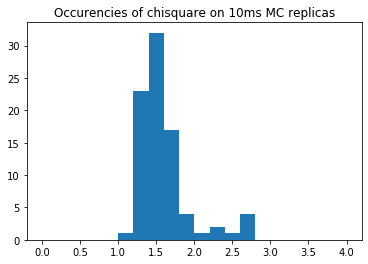

In [43]:
print(chi_array)
np.savetxt('Data/Results/Chi2hist_Nrep=50_10ms', chi_array, delimiter=',', fmt='%f')
plt.hist(chi_array, bins=20, range=[0, 4])
plt.title('Occurencies of chisquare on 10ms MC replicas')
plt.savefig('Figures/Chi2_hist_10')
plt.show()


In [ ]:
plt.plot(df_train[:,0], train_y, 'o', alpha=.5, color='lightpink', label='One set of MC data points')
plt.plot(df_train[:,0], predictions_values, 'x', label='$y_{pred}$')
#plot_uncertainties(x_train, y_train, nbins, minval, maxval)
#plt.legend()
plt.xlabel(r'Energy loss [eV]')

plt.title('Extrapolation of 10ms peak')
plt.savefig('Figures/Extrapolation')
plt.show()

In [ ]:
%run Evaluate_pseudodata.ipynb

#plt.plot(train_x, train_y,'o')
#plt.plot(pseudo_x, pseudo_pred, 'x', color='lightblue', label='Predictions')
plt.title('Mean for 36 replicas of 320 data points (100ms)')
pseudo_meanvector = np.linspace(-1,1,40)
plt.plot(pseudo_meanvector, pseudo10_mean, 'o', label = 'Predictions pseudodata')
plt.grid(True)
plt.plot(np.linspace(minval, maxval, 40), mean_t, 'o', label='Trainingsdata ')
plt.xlabel(r'Energy loss (normalized) [eV]')
plt.ylabel(r'counts [a.u]')
plt.legend()
plt.show()

plt.grid(True)
plt.xlabel(r'MC predictions')
plt.ylabel(r'training data')
plt.plot(np.linspace(0,1,10), np.linspace(0,1,10), color='lightgrey')
plt.plot(pseudo10_mean, mean_t, 'o')
plt.title('Central values')
plt.show()

In [ ]:
plt.plot(pseudo_meanvector, pseudo10_std, 'o', label = 'std pred pseudodata')
plt.grid(True)
plt.plot(np.linspace(minval, maxval, 40), std_t, 'o', label='std trainingsdata ')
plt.xlabel(r'Energy loss (normalized) [eV]')
plt.ylabel(r'counts [a.u]')
plt.legend()
plt.show()

plt.grid(True)
plt.xlabel(r'MC predictions')
plt.ylabel(r'training data')
plt.plot(np.linspace(0,0.1,10), np.linspace(0,0.1,10), color='lightgrey')
plt.plot(pseudo10_std, std_t, 'o')
plt.title('Std')
plt.show()